# Draft of H3 evaluation
grid-cell wise comparison of metrics
* `base`: the ground truth (manually simplified)
* `comp`: the method to compare (for now, as example: the parenx/voronoi simplification)

In [1]:
import os

import contextily as cx
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import utils
from matplotlib import cm, colors

settings

In [2]:
# which FUA?
fua = 869

# which h3 resolution?
res = 9

base_crs = "EPSG:4326"

# baseinal OSM data
orig_file = f"../data/{fua}/roads_osm.parquet"

# which file to take as baseline?
base_file = f"../data/{fua}/manual/{fua}.parquet"

read in metadata for this FUA

In [3]:
meta = utils.read_sample_data()
geom = meta.loc[meta.eFUA_ID == fua, "geometry"]
city = meta.loc[meta.eFUA_ID == fua, "eFUA_name"].values[0]

read in original OSM data, and base (manual) and comp (automated method) datasets

In [4]:
# read in orig OSM data
orig = utils.read_parquet_roads(fua)
orig = orig[["geometry"]]

# read in base case (manual simp)
base = utils.read_manual(fua, proj_crs=orig.crs)

# which file to compare with?
comp = utils.read_parenx(fua, "voronoi", proj_crs=orig.crs)

/Users/anvy/Library/CloudStorage/OneDrive-ITU/projects/simplification/code/utils.py:217: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf = gdf.explode(ingore_index=True)


In [5]:
# get graphs & node/edge gdfs for both data sets
base_graph = mm.gdf_to_nx(base, length="length", integer_labels=True)
comp_graph = mm.gdf_to_nx(comp, length="length", integer_labels=True)
nodes_base, edges_base = mm.nx_to_gdf(base_graph)
nodes_comp, edges_comp = mm.nx_to_gdf(comp_graph)
# add node degree to nodes df
nodes_base = utils.add_node_degree(nodes_base, base_graph)
nodes_comp = utils.add_node_degree(nodes_comp, comp_graph)

# Making h3 grid for this FUA

In [6]:
grid = utils.make_grid(fua, res, proj_crs=orig.crs)
grid.head()

,geometry,hex_id
0,"POLYGON ((306957.396 -4080084.582, 306864.841 ...",89bb50015bbffff
1,"POLYGON ((309125.948 -4085686.468, 309033.408 ...",89bb500363bffff
2,"POLYGON ((302560.744 -4082793.601, 302468.146 ...",89bb5000487ffff
3,"POLYGON ((307042.263 -4084666.586, 306949.705 ...",89bb5003007ffff
4,"POLYGON ((305566.173 -4083676.987, 305473.601 ...",89bb500311bffff


In [7]:
assert grid.crs == base.crs
assert grid.crs == comp.crs

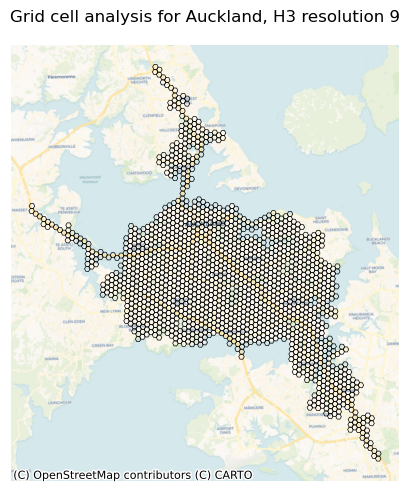

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
ax.set_axis_off()
# base.plot(ax=ax, linewidth = 0.1, alpha = 0.5, color = "blue")
grid.boundary.plot(ax=ax, linewidth=0.5, alpha=1, color="black")
ax.set_title(f"Grid cell analysis for {city}, H3 resolution {res}")
cx.add_basemap(ax=ax, crs=grid.crs, source=cx.providers.CartoDB.Voyager)

# Cell-wise evaluation

For evaluation: add gridcell-wise analysis of metrics:
* `geom_count`: computes total nr of geoms in a cell (after `clip`ping) 
* `cell_length`: computes total length of geoms in a cell
* `node_count`: number of nodes in cell
* `degree_distr`: node degree distribution in cell 
* `avg_degree`: average node degree in cell
* displacement
* feature matching

For use cases: 
* code to zoom in to separate gridcells for use case checking

In [9]:
# add columns with geom stats and node stats
for name, gdf, node_gdf in zip(
    ["base", "comp"], [base, comp], [nodes_base, nodes_comp]
):
    grid[[f"geom_count_{name}", f"cell_length_{name}"]] = grid.apply(
        lambda x: utils.get_geom_stats(gdf, x.geometry), axis=1, result_type="expand"
    )
    grid[
        [f"node_count_{name}", f"node_degrees_{name}", f"avg_degree_{name}"]
    ] = grid.apply(
        lambda x: utils.get_node_stats(node_gdf, x.geometry),
        axis=1,
        result_type="expand",
    )

# add ratio columns
for var in ["geom_count", "cell_length", "node_count", "avg_degree"]:
    grid[f"{var}_ratio"] = grid[f"{var}_comp"] / grid[f"{var}_base"]

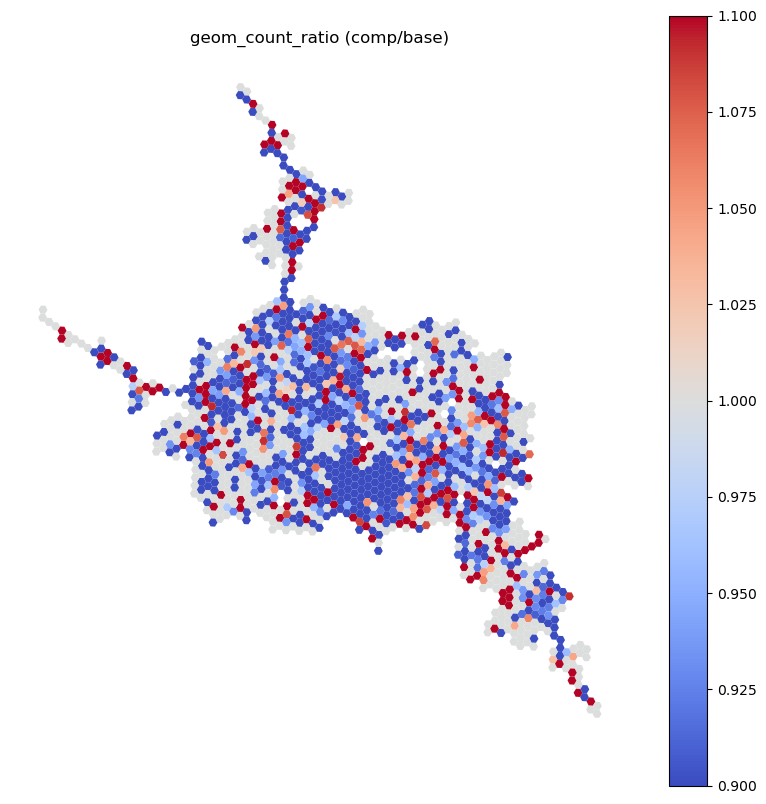

In [10]:
var = "geom_count_ratio"
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
cmap = cm.coolwarm
grid.plot(
    ax=ax, column=var, norm=colors.CenteredNorm(vcenter=1), cmap=cmap, legend=True
)
ax.set_title(f"{var} (comp/base)")

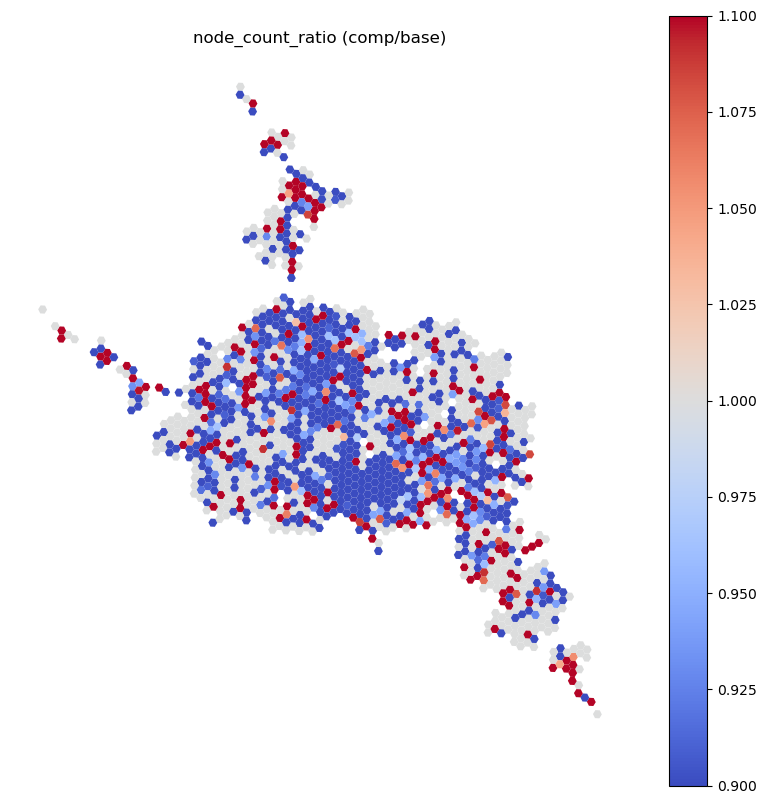

In [11]:
var = "node_count_ratio"
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
cmap = cm.coolwarm
grid.plot(
    ax=ax, column=var, norm=colors.CenteredNorm(vcenter=1), cmap=cmap, legend=True
)
ax.set_title(f"{var} (comp/base)")

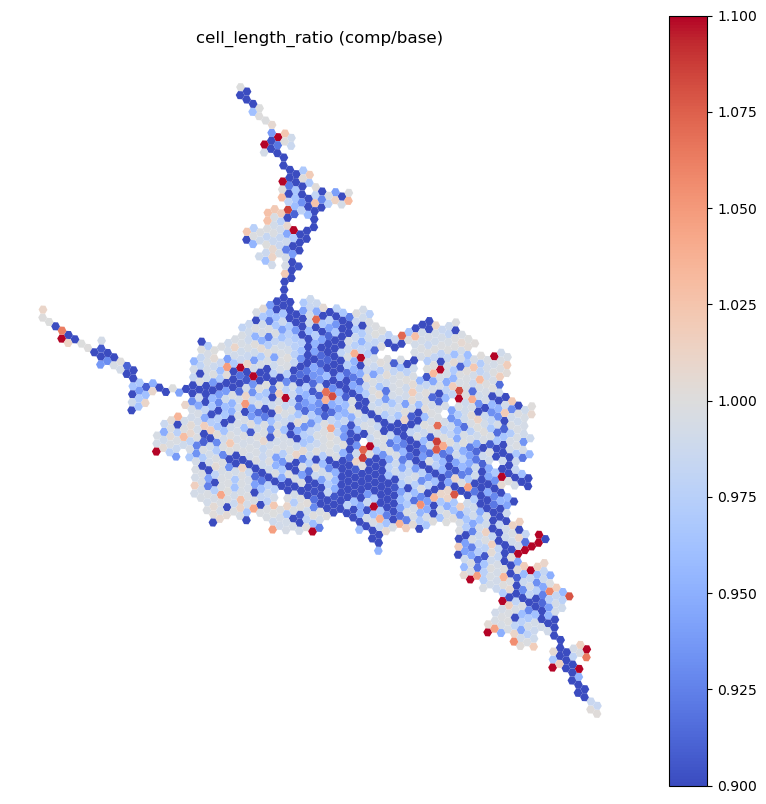

In [12]:
var = "cell_length_ratio"
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
cmap = cm.coolwarm
grid.plot(
    ax=ax, column=var, norm=colors.CenteredNorm(vcenter=1), cmap=cmap, legend=True
)
ax.set_title(f"{var} (comp/base)")

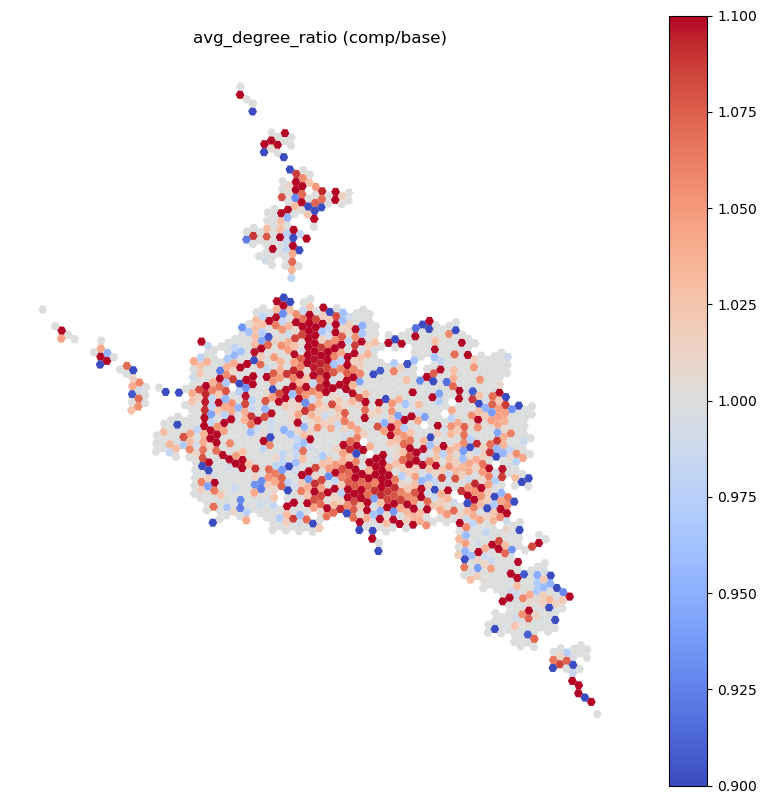

In [13]:
var = "avg_degree_ratio"
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
cmap = cm.coolwarm
grid.plot(
    ax=ax, column=var, norm=colors.CenteredNorm(vcenter=1), cmap=cmap, legend=True
)
ax.set_title(f"{var} (comp/base)")

# Zoom-in plot of one specific grid cell

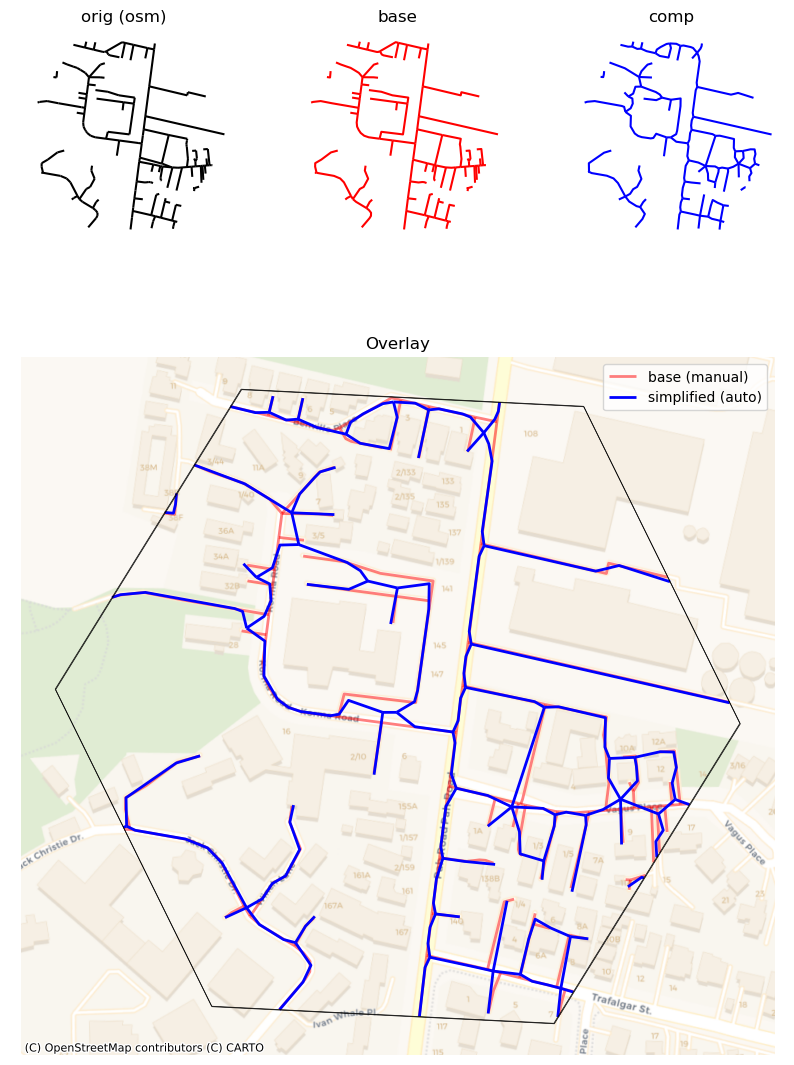

In [15]:
grid_id = 20  # which cell to plot
fig, ax = utils.plot_cell(grid_id, grid, orig, base, comp)
plt.show()

## Generate single cell plots 
... for top 10 instances where total geom length in comp is higher than in manual

In [ ]:
subfolder = f"../usecases/{fua}/totallength/"
os.makedirs(subfolder, exist_ok=True)
cells_to_plot = (
    grid[grid.cell_length_ratio > 1]
    .sort_values(by="cell_length_ratio", ascending=False)
    .index[0:10]
)

In [ ]:
for id in cells_to_plot:
    ratio = np.round(grid.loc[id, "cell_length_ratio"], 3)
    fig, ax = utils.plot_cell(id, grid=grid, orig=orig, base=base, comp=comp)
    plt.suptitle(f"Total length ratio comp/base: {ratio}")
    plt.tight_layout()
    fig.savefig(subfolder + f"{id}.png", dpi=300, bbox_inches="tight")
    plt.close()

## Generate single cell plots 
... for top 10 instances where average node degree in comp is lower than in manual

In [ ]:
subfolder = f"../usecases/{fua}/averagedegree/"
os.makedirs(subfolder, exist_ok=True)
cells_to_plot = (
    grid[(grid.avg_degree_ratio < 1) & (grid.avg_degree_ratio > 0)]
    .sort_values(by="avg_degree_ratio", ascending=True)
    .index[0:10]
)

for id in cells_to_plot:
    ratio = np.round(grid.loc[id, "avg_degree_ratio"], 3)
    fig, ax = utils.plot_cell(id, grid=grid, orig=orig, base=base, comp=comp)
    plt.suptitle(f"Average node degree ratio comp/base: {ratio}")
    plt.tight_layout()
    fig.savefig(subfolder + f"{id}.png", dpi=300, bbox_inches="tight")
    plt.close()